In [1]:
import pandas as pd
import yaml
import argparse
import torch
from model import YNet

In [2]:
%load_ext autoreload
%autoreload 2

#### Some hyperparameters and settings

In [3]:
CONFIG_FILE_PATH = 'config/atc_longterm.yaml'  # yaml config file containing all the hyperparameters
DATASET_NAME = 'atc'

TEST_DATA_PATH = 'data/ATC/test_longterm.pkl'
TEST_IMAGE_PATH = 'data/ATC/test'
OBS_LEN = 5  # in timesteps
PRED_LEN = 30  # in timesteps
NUM_GOALS = 20  # K_e
NUM_TRAJ = 1  # K_a

ROUNDS = 3  # Y-net is stochastic. How often to evaluate the whole dataset
BATCH_SIZE = 8

#### Load config file and print hyperparameters

In [4]:
with open(CONFIG_FILE_PATH) as file:
    params = yaml.load(file, Loader=yaml.FullLoader)
experiment_name = CONFIG_FILE_PATH.split('.yaml')[0].split('config/')[1]
params

{'resize': 0.055,
 'batch_size': 8,
 'viz_epoch': 10,
 'learning_rate': 0.0001,
 'num_epochs': 300,
 'encoder_channels': [32, 32, 64, 64, 64],
 'decoder_channels': [64, 64, 64, 32, 32],
 'waypoints': [14, 29],
 'temperature': 1.8,
 'segmentation_model_fp': 'segmentation_models/SDD_segmentation.pth',
 'semantic_classes': 2,
 'loss_scale': 1000,
 'kernlen': 31,
 'nsig': 4,
 'use_features_only': False,
 'unfreeze': 100,
 'use_TTST': True,
 'rel_threshold': 0.002,
 'use_CWS': True,
 'CWS_params': {'sigma_factor': 6, 'ratio': 2, 'rot': True}}

#### Load preprocessed Data

#### Initiate model and load pretrained weights

In [5]:
model = YNet(obs_len=OBS_LEN, pred_len=PRED_LEN, params=params)

/usr/local/anaconda3/envs/ynet-env/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'segmentation_models_pytorch.unet.model.Unet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/anaconda3/envs/ynet-env/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'segmentation_models_pytorch.encoders.resnet.ResNetEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/anaconda3/envs/ynet-env/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' ha

In [6]:
import cv2
import os
from utils.image_utils import create_gaussian_heatmap_template, create_dist_mat, \
	preprocess_image_for_segmentation, pad, resize

In [80]:
test_images = {}
scene = 'scene'
image_file = 'ATC_Scence.png'
# test_images[scene] = cv2.imread(os.path.join('data/ATC/test', scene, image_file),cv2.IMREAD_GRAYSCALE)
test_images[scene] = cv2.imread(os.path.join('data/ATC/test', scene, image_file))



In [8]:
division_factor = 2 ** len(params['encoder_channels'])

In [9]:
division_factor

32

In [10]:
img = cv2.resize(test_images[scene], (0,0), fx=0.055, fy=0.055, interpolation=cv2.INTER_AREA)
img.shape

(304, 500, 3)

In [81]:
print(test_images[scene].shape)
resize(test_images, factor=params['resize'], seg_mask=False)
print(test_images[scene].shape)
# make sure that image shape is divisible by 32, for UNet architecture
pad(test_images, division_factor=division_factor)

(5531, 9087, 3)
(304, 500, 3)


In [66]:
preprocess_image_for_segmentation(test_images, seg_mask=False,classes=params['semantic_classes'])

ValueError: operands could not be broadcast together with shapes (320,512) (3,) 

In [29]:
params['semantic_classes'] = 2

In [89]:
from utils.image_utils import heat_map_show

import torchvision.transforms as transforms
transform1 = transforms.Compose([
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    ]
)
tttt = transform1(test_images[scene])





torch.Size([3, 320, 512]) tensor(1.) tensor(0.)


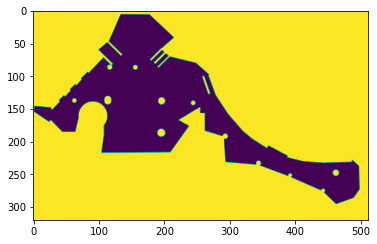

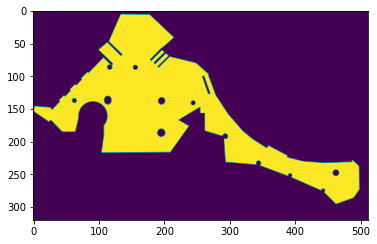

In [90]:
print(tttt.shape, tttt.max(), tttt.min())
heat_map_show(1-tttt[0])
heat_map_show(tttt[0])

In [91]:
p = torch.zeros((1,2,tttt.shape[1],tttt.shape[2]))

In [93]:
p[0][0] = tttt[0]
p[0][1] = 1 - tttt[0]
heat_map_show(p[0][0])
heat_map_show(p[0][1])

p.shape

torch.Size([1, 2, 320, 512])

#### Evaluate model

In [63]:
test_images[scene][1]

tensor([[0.0204, 0.0204, 0.0204,  ..., 0.0204, 0.0204, 0.0204],
        [0.0204, 0.0204, 0.0204,  ..., 0.0204, 0.0204, 0.0204],
        [0.0204, 0.0204, 0.0204,  ..., 0.0204, 0.0204, 0.0204],
        ...,
        [0.0204, 0.0204, 0.0204,  ..., 0.0204, 0.0204, 0.0204],
        [0.0204, 0.0204, 0.0204,  ..., 0.0204, 0.0204, 0.0204],
        [0.0204, 0.0204, 0.0204,  ..., 0.0204, 0.0204, 0.0204]])

In [56]:
img = test_images[scene][0]
print(img.max(),img.min())

tensor(2.2489) tensor(-2.1179)


In [ ]:
model.evaluate(df_test, params, image_path=TEST_IMAGE_PATH,
               batch_size=BATCH_SIZE, rounds=ROUNDS, 
               num_goals=NUM_GOALS, num_traj=NUM_TRAJ, device=None, dataset_name=DATASET_NAME)